- **author_id** (id исполнителя)<br> 
- **ratio** (величина показывающая на сколько процентов прослушали трек. 1 - в среднем слушают полностью трек, > 1 - несколько раз подряд в среднем, < 1 - не дослушивают до конца в среднем)<br> 
- **playstart** (среднее время начала трека в плейлисте у исполнителя)<br> 
- **likes** (количество лайков у треков исполнителя)<br> 
- **duration** (средняя продолжительность треков исполнителя)<br> 
- **albums** (количество альбомов)<br> 
- **real_count_tracks** (сколько раз прослушали треки с повторами)<br> 
- **count_tracks** (сколько всего треков)<br> 



Я показал на самом простом методе кластеризацию k-means, после использовал методы поиска ближайщих соседей с кроссвалидацией(KD-tree, ball_tree, brute). Также использовал более сложные методы faiss, annoy. Попытался дать максимальные комментарии, что у

Прошу дать максимальный фидбэк (лучше всего что не так и где можно лучше) по моей работе - это будет лучшая оценка моего труда и уважение моего времени.

У меня случился небольшой казус с загрузкой, но переделав работу получилось сделать больше и лучше. Естественно можно еще улучшать и структурировать работу, пока это все что успел.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
from tqdm import tnrange

import faiss
import annoy

In [3]:
authors = pd.read_csv('authors.csv')
authors

,name,person_id
0,Everything+Is+Illuminated,145148
1,Robin+O%27Brien,297899
2,Nicholas+Gunn++(2012),250429
3,Aspasia+Stratigou,32765
4,Allison+Veltz,18689
...,...,...
560912,Sanaa+Kariakoo,544215
560913,Rock-a-teens,298403
560914,Jennifer+Lopez+Ft.+DJ+Mustard,450896
560915,Bobby+Sanabria+Conducting+The+Manhattan+School...,53831


In [4]:
data = pd.read_csv('prepared_authors_history.csv')
data

,author_id,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks
0,1,1.358182,6180.363636,0,0.0,1,11,1
1,2,1.080000,3592.000000,0,0.0,1,1,1
2,3,1.485000,2187.000000,0,0.0,1,2,1
3,5,1.092500,28097.750000,1,0.0,1,4,2
4,6,1.020000,1692.000000,0,0.0,1,1,1
...,...,...,...,...,...,...,...,...
405282,473975,0.980000,5941.000000,0,299000.0,1,1,1
405283,473976,0.975000,6490.333333,0,0.0,1,6,4
405284,473977,1.000000,8177.000000,0,0.0,1,1,1
405285,473978,1.165577,5232.096154,1,218300.0,1,52,12


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405287 entries, 0 to 405286
Data columns (total 8 columns):
author_id            405287 non-null int64
ratio                405287 non-null float64
playstart            405287 non-null float64
likes                405287 non-null int64
duration             405287 non-null float64
albums               405287 non-null int64
real_count_tracks    405287 non-null int64
count_tracks         405287 non-null int64
dtypes: float64(3), int64(5)
memory usage: 24.7 MB


In [6]:
data.describe()

,author_id,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks
count,405287.000000,405287.000000,4.052870e+05,405287.000000,4.052870e+05,405287.000000,405287.000000,405287.000000
mean,237994.341945,1.279369,4.611429e+03,4.068559,1.043201e+05,1.558851,63.765490,9.402293
std,136586.255468,2.315857,1.519534e+04,56.224388,5.235807e+06,2.397964,766.817648,47.316403
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,1.000000,1.000000
25%,120773.000000,0.990000,1.288000e+03,0.000000,0.000000e+00,1.000000,1.000000,1.000000
50%,238143.000000,1.010000,2.995205e+03,0.000000,0.000000e+00,1.000000,2.000000,2.000000
75%,356080.500000,1.140000,5.499522e+03,0.000000,2.000000e+05,1.000000,9.000000,6.000000
max,473980.000000,597.000000,8.619485e+06,8526.000000,3.276925e+09,177.000000,94439.000000,15881.000000


Построим графики распределений для признаков, просто взглянутт на данные, как распределены.

Text(0.5, 0.98, 'Distribution of quantitative characteristics')

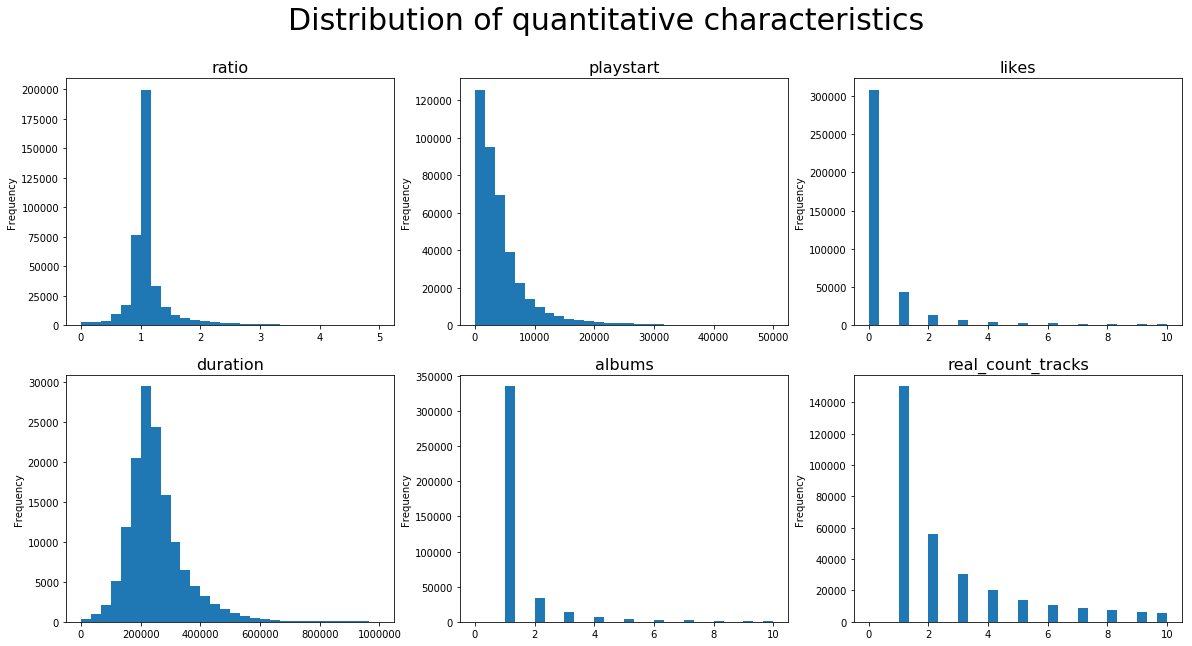

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))


data['ratio'].plot.hist(range=(0, 5), bins=30, ax=ax[0,0])
ax[0,0].set_title('ratio', fontsize=16)

data['playstart'].plot.hist(range=(0, 50000), bins=30, ax=ax[0,1])
ax[0,1].set_title('playstart', fontsize=16)

data['likes'].plot.hist(range=(0, 10), bins=30, ax=ax[0,2])
ax[0,2].set_title('likes', fontsize=16)

data[data['duration'] > 0]['duration'].plot.hist(range=(0, 1000000), bins=30, ax=ax[1,0])
ax[1,0].set_title('duration', fontsize=16)

data['albums'].plot.hist(range=(0, 10), bins=30, ax=ax[1,1])
ax[1,1].set_title('albums', fontsize=16)

data['real_count_tracks'].plot.hist(range=(0, 10), bins=30, ax=ax[1,2])
ax[1,2].set_title('real_count_tracks', fontsize=16)


fig.suptitle('Distribution of quantitative characteristics', fontsize=30)

Видно что несколько принимают нормальное распределение и несколько пуассоновское.

Далее удалил пару выбросов, чтобы в кластеризации они не образовывали отдельный кластер. Строго говоря это не выбросы и их удалять нельзя, но я так поступил, чтобы была нагляднее кластеризация.

In [8]:
data = data[data['duration'] < 1000000000]

In [9]:
data = data[data['playstart'] < 1000000]

In [10]:
features = data.drop('author_id', 1)
target = data['author_id']

Обязательно масштабируем наши признаки, так как все были в разных шкалах измерений и методе кластеризации признак с большей шкалой мог сильнее повлиять на расстояние в n-мерном пространстве векторов, которыми мы определяем наши объекты.

In [11]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled

array([[ 0.03403122,  0.25381582, -0.07236307, ..., -0.23304694,
        -0.068811  , -0.1775723 ],
       [-0.08608893, -0.15814965, -0.07236307, ..., -0.23304694,
        -0.08185187, -0.1775723 ],
       [ 0.08879188, -0.38177027, -0.07236307, ..., -0.23304694,
        -0.08054779, -0.1775723 ],
       ...,
       [-0.12063329,  0.57160164, -0.07236307, ..., -0.23304694,
        -0.08185187, -0.1775723 ],
       [-0.04913643,  0.10288902, -0.05457723, ..., -0.23304694,
        -0.0153434 ,  0.05490581],
       [-0.3149453 , -0.41805888, -0.07236307, ..., -0.23304694,
        -0.08185187, -0.1775723 ]])

In [12]:
n_clusters=30
cost=[]
for i in tnrange(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(features_scaled)
    cost.append(kmean.inertia_)  

Ниже график каменистой осыпи, по y указана величина среднеквадратичное расстояние в кластерах размера k (SSE). И там где резко меняется расстояние, значит мы хорошо разбили на кластеры и стоит попробовать провести кластеризацию с этим количеством кластеров и после уже посмотреть на то, как сгруппировал метод объекты.


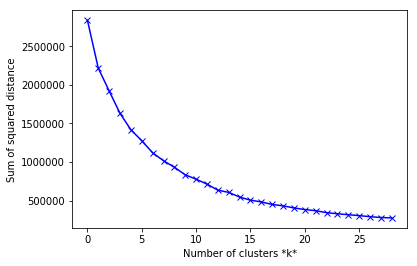

In [13]:
plt.plot(cost, 'bx-')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Пробовал кластеризовать с 6-8-9-10, остановился на 8 потому, сколько объектов в каждом кластере. То есть при 10 кластерах, получались некоторые кластеры с одним элементом.

In [14]:
kmean= KMeans(8, random_state=12345)
kmean.fit(features_scaled)
labels=kmean.labels_

In [15]:
clusters=pd.concat([data.reset_index(drop=True), pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,author_id,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks,cluster
0,1,1.358182,6180.363636,0,0.0,1,11,1,1
1,2,1.080000,3592.000000,0,0.0,1,1,1,1
2,3,1.485000,2187.000000,0,0.0,1,2,1,1
3,5,1.092500,28097.750000,1,0.0,1,4,2,0
4,6,1.020000,1692.000000,0,0.0,1,1,1,1


In [16]:
mean_of_features_by_clusters = pd.DataFrame(columns=['ratio', 'playstart', 'likes', 'duration', 'albums',
       'real_count_tracks', 'count_tracks', 'cluster', 'lenght'])

for i in range(8):
    first = pd.DataFrame(np.array(clusters[clusters['cluster'] == i].describe().loc['mean']).reshape(1,9), columns=clusters.columns)
    first = first.drop('author_id', 1)
    first['lenght'] = len(clusters[clusters['cluster'] == i])

    mean_of_features_by_clusters = pd.concat([mean_of_features_by_clusters, first])


Мини датафрейм с кратким описанием каждого кластера.

In [17]:
mean_of_features_by_clusters

,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks,cluster,lenght
0,1.131891,22062.863547,0.401576,6.749746e+04,1.133859,9.909611,3.284141,0.0,25512
0,1.149518,3366.775670,0.989195,8.929343e+04,1.294542,18.732559,5.888813,1.0,365187
0,1.129565,5221.701098,2646.011111,2.693186e+05,50.422222,34880.755556,1319.300000,2.0,90
0,206.148317,3776.611061,0.350000,1.350000e+04,1.050000,8.350000,3.700000,3.0,20
0,0.352032,3473.606760,83.000000,2.115644e+08,9.000000,1023.500000,126.833333,4.0,6
0,1.132073,5502.699397,628.906077,2.639148e+05,27.501381,9343.009669,462.893646,5.0,724
0,1.135121,5063.831650,61.589386,3.317756e+05,10.682313,932.310604,117.557036,6.0,9459
0,12.612894,3189.534908,0.209053,1.127391e+04,1.055763,4.862809,2.221885,7.0,4286


In [31]:
X = features_scaled
y = clusters['cluster']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [33]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [34]:
knn.score(X_test, y_test)

0.9986922782733139

In [403]:
%%time

knn_cv = KNeighborsClassifier(n_neighbors = 20)
cv_scores = cross_val_score(knn_cv, X, y, cv=10)
print(cv_scores)
print("cv_scores mean:{}".format(np.mean(cv_scores)))

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.26192297 0.4059362  0.4456452  0.44451024 0.45796837 0.47696711
 0.50445382 0.55887578 0.54416918 0.91143738]
cv_scores mean:0.5011886252270623
CPU times: user 28min 44s, sys: 8.7 s, total: 28min 53s
Wall time: 28min 37s


Кросс валидация показала, что нам повезло при оценке алгоритма и именно таком разделении, так как средняя точность метода составила 50 процентов, а без кросс валидации 95%.

In [413]:
%%time

knn2 = KNeighborsClassifier(n_neighbors = 20)
param_grid = {'algorithm': ["auto", "ball_tree", "kd_tree", "brute"]}
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
knn_gscv.fit(X, y)

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 3h 19min 48s, sys: 17min 1s, total: 3h 36min 50s
Wall time: 2h 45min 36s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=20, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                       'brute']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [414]:
knn_gscv.best_params_

{'algorithm': 'auto'}

In [415]:
knn_gscv.best_score_

0.5011818872691742

С поиском 20 соседей, перебрали несколько алгоритмов (KDtree, BallTree and Brute). В итоге лучшую точность показал параметр auto.

In [44]:
distances, indices = knn.kneighbors(np.array(features_scaled[0]).reshape(1, -1))

In [54]:
results_k = data.loc[data['author_id'].isin(indices[0])]
results_k['name'] = authors[authors['person_id'].isin(results_k['author_id'])]['name'].values
results_k

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,author_id,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks,name
595,819,0.760000,10240.000000,0,0.000000,1,1,1,MihayLove+feat.+Veela
22711,27330,0.980000,1205.000000,1,0.000000,1,1,1,%C3%80.+%C3%98%C3%A8%C3%B0%C3%BF%C3%A5%C3%A2+(...
28719,34314,1.214000,702.200000,0,0.000000,1,5,3,GOBLIN+TEA
50390,59460,1.065000,4008.000000,0,0.000000,1,2,1,08+-+Kalmah+-+Seventh+Swamphony+(2013)
54049,63704,1.000000,3523.000000,0,0.000000,1,1,1,Miedlev
58669,69071,1.010000,8321.000000,0,0.000000,1,1,1,Saskia+Lankhoorn
91065,108686,1.005667,2012.209302,0,298500.000000,2,43,44,DeathBoy
136532,161443,1.060476,5352.333333,4,295833.333333,4,21,11,nakano+kills+me
142637,168495,0.990000,9767.000000,0,0.000000,1,1,1,Antmusic+(Single+version)
155444,183438,0.877333,1755.333333,6,492000.000000,2,15,6,Serendipity+(Motion+Picture+Soundtrack)


In [404]:
class ExactIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
    def build(self):
        self.index = faiss.IndexFlatL2(self.dimension,)
        self.index.add(self.vectors)
        
    def query(self, vectors, k=20):
        distances, indices = self.index.search(vectors, k) 
        return [self.labels[i] for i in indices[0]]

In [405]:
index = ExactIndex(np.ascontiguousarray(features_scaled), target)
index.build()

In [406]:
exactIndex = index.query(np.array(features_scaled[0], dtype='float32').reshape(1, 7))
exactIndex

[1,
 222986,
 81740,
 221105,
 282679,
 229348,
 116082,
 93657,
 399237,
 205380,
 165289,
 244335,
 402035,
 419571,
 401475,
 154490,
 435165,
 344514,
 214195,
 265586]

In [407]:
results_exact = data.loc[data['author_id'].isin(exactIndex)]
results_exact['name'] = authors[authors['person_id'].isin(exactIndex)]['name'].values
results_exact

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,author_id,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks,name
0,1,1.358182,6180.363636,0,0.000000,1,11,1,00-01
69638,81740,1.360000,6186.000000,0,0.000000,1,1,1,Tapper+Zukie
79312,93657,1.360000,6288.000000,0,0.000000,1,2,1,Mason+feat.+Roisin+Murphy
97450,116082,1.230000,4944.333333,0,0.000000,1,3,3,HOTSTREETS
130607,154490,1.000000,6102.000000,0,0.000000,1,2,1,DJ+Fresca
139852,165289,0.920000,4355.000000,0,124000.000000,1,2,1,"For+Children,+Vol.3:+No+18+Sostenuto+(Teasing+..."
174366,205380,0.970000,1607.000000,0,0.000000,1,1,1,Man%27s+Gin
181987,214195,1.029014,3017.140845,0,427000.000000,2,142,23,DJ+LENGUA
188017,221105,0.923333,2508.333333,0,276000.000000,1,3,3,Wedlock+vs.+Comababy
189635,222986,0.952632,11273.368421,0,0.000000,1,19,1,Los+Giovanes


In [13]:
class AnnoyIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
    def build(self, number_of_trees=20):
        self.index = annoy.AnnoyIndex(self.dimension, metric='angular')
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=20):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=20)                                           
        return [self.labels[i] for i in indices]

In [14]:
index = AnnoyIndex(np.ascontiguousarray(features_scaled), target)
index.build()

In [15]:
annoyIndex = index.query(np.array(features_scaled[0], dtype='float32'))
annoyIndex

[1,
 222986,
 81740,
 221105,
 229348,
 116082,
 399237,
 205380,
 165289,
 402035,
 164224,
 244465]

In [16]:
results_annoy = data.loc[data['author_id'].isin(annoyIndex)]
results_annoy['name'] = authors[authors['person_id'].isin(annoyIndex)]['name'].values
results_annoy

/Users/gleb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,author_id,ratio,playstart,likes,duration,albums,real_count_tracks,count_tracks,name
0,1,1.358182,6180.363636,0,0.000000,1,11,1,00-01
69638,81740,1.360000,6186.000000,0,0.000000,1,1,1,Mason+feat.+Roisin+Murphy
97450,116082,1.230000,4944.333333,0,0.000000,1,3,3,George+Clinton
138927,164224,1.026723,6045.324000,18,342159.090909,10,250,99,DJ+LENGUA
139852,165289,0.920000,4355.000000,0,124000.000000,1,2,1,Na%C3%A7%C3%A3o+Zumbi
174366,205380,0.970000,1607.000000,0,0.000000,1,1,1,Wedlock+vs.+Comababy
188017,221105,0.923333,2508.333333,0,276000.000000,1,3,3,Los+Giovanes
189635,222986,0.952632,11273.368421,0,0.000000,1,19,1,Mat+Zo+Featuring+Janai
195093,229348,0.970000,3539.000000,0,0.000000,1,1,1,William+Butler+&+Owen+Pallet
207985,244465,1.038413,3261.324182,48,225528.301887,4,947,101,Clotaire+1er
